# Variance partitioning for the training data

Here we will go head and analyze the explained variances in the training data by using the previously identified significant microbes and SNPs.

In [1]:
from pyplink import PyPlink
import pandas as pd
import pickle
import statsmodels.formula.api as smf
from statsmodels.stats.multitest import fdrcorrection
from rich.progress import track
import arivale_data_interface as adi
from utils import rsid2gene, summarize_associations
import warnings
warnings.simplefilter("ignore")

/users/cdiener/miniconda3/envs/gxe2021/lib/python3.8/site-packages/arivale_data_interface/snapshots_interface.py:31: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  DEPRECATIONS = yaml.load(in_yaml)


We start by reading the actual data which includes the genotypes, CLR-transformed microbe abundances and metabolite abundances.

In [2]:
metabolites = pd.read_csv("data/train.csv")
microbes = pd.read_csv("data/genera_clr_filtered.csv")
microbes = microbes[microbes.stool_sample_id.isin(metabolites.stool_sample_id)]
genotypes = PyPlink("input_bed/all_chr/all_genomes_09112019_all_chr")

We follow that by reading all the significant features we want to use.

In [3]:
sig_microbes = pd.read_csv("data/sig_metabolite_taxon.csv")
sig_snps = pd.read_csv("data/final_results.csv")
sig_snps["rsid"] = sig_snps.SNP.str.split(";").str[0]
genes = rsid2gene(sig_snps.rsid.unique())
sig_snps = sig_snps.merge(genes, left_on="rsid", right_on="snp", how="left")

This is all the data we need to calculate the R² values for the metabolites.

## Variances explained by the microbiome

We start by calculating the variances explained by the genus-level abundances.

In [4]:
micro_r2 = []
micro_fits = {}
metabolites_and_microbes = pd.merge(metabolites, microbes, on="stool_sample_id")
for met in track(sig_microbes.metabolite.unique()):
    mics = sig_microbes.taxon[sig_microbes.metabolite == met]
    mterms = ["Q('%s')" % m for m in mics]
    formula = f"{met} ~ {' + '.join(mterms)}"
    fit = smf.ols(formula, data=metabolites_and_microbes).fit()
    metrics = pd.DataFrame({
        "metabolite": met,
        "n_taxa": len(mics),
        "micro_r2": fit.rsquared,
        "micro_f": fit.fvalue,
        "micro_p": fit.f_pvalue
    }, index=[met])
    micro_fits[met] = fit
    micro_r2.append(metrics)
with open("data/train_micro_fits.pkl", "wb") as out:
    pickle.dump(micro_fits, out)
micro_r2 = pd.concat(micro_r2)
micro_r2["micro_q"] = fdrcorrection(micro_r2.micro_p)[1]

Output()

In [5]:
micro_r2.micro_q.describe()

count    7.050000e+02
mean     3.529643e-03
std      9.362273e-03
min      2.858785e-79
25%      9.639433e-06
50%      3.053355e-04
75%      2.762471e-03
max      8.667910e-02
Name: micro_q, dtype: float64

## Variances explained by the genotype

Now we will do the same thing for the genotypes. We will treat the allele groups as categorical variables with homozygous major allele as the reference group.

In [6]:
geno_r2 = []
geno_fits = {}
genome_ids = genotypes.get_fam().iid.values
for met in track(sig_snps.metabolite.unique()):
    snps = sig_snps.SNP[sig_snps.metabolite == met] #.str.split(";").str[0]
    snp_terms = ["Q('%s')" % s for s in snps]
    geno = pd.DataFrame({s: genotypes.get_geno_marker(s) for s in snps}, index=genome_ids)
    df = pd.merge(metabolites[["genome_id", met]], geno, left_on="genome_id", right_index=True)
    formula = f"{met} ~ {' + '.join(snp_terms)}"
    fit = smf.ols(formula, data=df).fit()
    metrics = pd.DataFrame({
        "metabolite": met,
        "n_taxa": len(mics),
        "geno_r2": fit.rsquared,
        "geno_f": fit.fvalue,
        "geno_p": fit.f_pvalue
    }, index=[met])
    geno_r2.append(metrics)
    geno_fits[met] = fit
geno_r2 = pd.concat(geno_r2)
with open("data/train_geno_fits.pkl", "wb") as out:
    pickle.dump(geno_fits, out)
geno_r2["geno_q"] = fdrcorrection(geno_r2.geno_p)[1]

Output()

In [7]:
geno_r2.geno_q.describe()

count     1.820000e+02
mean      1.821843e-11
std       1.575108e-10
min      4.477878e-125
25%       1.154130e-26
50%       9.895465e-19
75%       6.503199e-13
max       2.111497e-09
Name: geno_q, dtype: float64

## Track the partitioning

Now we will combine the datasets and also merge in the metabolite names.

In [8]:
metabolite_meta = adi.get_snapshot("metabolomics_metadata", clean=True) [["CHEMICAL_ID", "BIOCHEMICAL_NAME", "SUPER_PATHWAY", "SUB_PATHWAY", "CAS", "KEGG"]]
metabolite_meta["metabolite"] = "metabolite_" + metabolite_meta.CHEMICAL_ID.astype(str)
joint_r_sq = pd.merge(micro_r2, geno_r2, on="metabolite", how="outer")
joint_r_sq = pd.merge(joint_r_sq, metabolite_meta, on="metabolite")
joint_r_sq[["micro_r2", "geno_r2"]] = joint_r_sq[["micro_r2", "geno_r2"]].fillna(0)
joint_r_sq[["micro_p", "geno_p"]] = joint_r_sq[["micro_p", "geno_p"]].fillna(1)
joint_r_sq['total'] = joint_r_sq['micro_r2'] + joint_r_sq['geno_r2'] 
joint_r_sq = joint_r_sq.sort_values('total', ascending = False)

joint_r_sq

,metabolite,n_taxa_x,micro_r2,micro_f,micro_p,micro_q,n_taxa_y,geno_r2,geno_f,geno_p,geno_q,CHEMICAL_ID,BIOCHEMICAL_NAME,SUPER_PATHWAY,SUB_PATHWAY,CAS,KEGG,total
118,metabolite_2054,1.0,0.007357,7.063628,7.998142e-03,8.851947e-03,2.0,0.530081,31.482224,2.460373e-127,4.477878e-125,2054,ethylmalonate,Amino Acid,"Leucine, Isoleucine and Valine Metabolism",601-75-2,NaN,0.537439
168,metabolite_100001054,3.0,0.030116,9.729471,2.515561e-06,9.852615e-06,2.0,0.489344,28.191535,3.602822e-111,3.278568e-109,100001054,butyrylcarnitine (C4),Lipid,Fatty Acid Metabolism (also BCAA Metabolism),25576-40-3,C02862,0.519460
309,metabolite_100002253,52.0,0.463013,13.978268,4.055014e-82,2.858785e-79,NaN,0.000000,NaN,1.000000e+00,NaN,100002253,cinnamoylglycine,Xenobiotics,Food Component/Plant,16534-24-0,NaN,0.463013
577,metabolite_100020550,16.0,0.065852,3.903629,3.793327e-07,1.923954e-06,2.0,0.374621,48.521517,3.042515e-83,9.228962e-82,100020550,deoxycholic acid glucuronide,Lipid,Secondary Bile Acid Metabolism,NaN,NaN,0.440473
722,metabolite_100001577,NaN,0.000000,NaN,1.000000e+00,NaN,2.0,0.426941,34.884546,2.446629e-84,9.852332e-83,100001577,N-acetylcitrulline,Amino Acid,Urea cycle; Arginine and Proline Metabolism,33965-42-3,C15532,0.426941
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154,metabolite_100000808,1.0,0.004247,3.864353,4.962725e-02,5.005323e-02,NaN,0.000000,NaN,1.000000e+00,NaN,100000808,cysteine s-sulfate,Amino Acid,"Methionine, Cysteine, SAM and Taurine Metabolism",1637-71-4,C05824,0.004247
585,metabolite_100021123,1.0,0.004228,3.893624,4.876966e-02,4.932943e-02,NaN,0.000000,NaN,1.000000e+00,NaN,100021123,"hydroxy-N6,N6,N6-trimethyllysine*",Amino Acid,Lysine Metabolism,NaN,NaN,0.004228
107,metabolite_1537,1.0,0.003593,3.436469,6.408069e-02,6.435454e-02,NaN,0.000000,NaN,1.000000e+00,NaN,1537,1-palmitoyl-2-linoleoyl-GPC (16:0/18:2),Lipid,Phospholipid Metabolism,40811-94-7,NaN,0.003593
115,metabolite_1869,1.0,0.003468,3.149374,7.629219e-02,7.650924e-02,NaN,0.000000,NaN,1.000000e+00,NaN,1869,2-hydroxyhippurate (salicylurate),Xenobiotics,Benzoate Metabolism,487-54-7,C07588,0.003468


We will now classify the metabolites into microbe-only, genotype-only and hybrid metabolites. After that we transform everything into a long data frame.

In [9]:
joint_r_sq["group"] = "hybrid"
joint_r_sq.loc[(joint_r_sq["micro_r2"] <= 0.01 * joint_r_sq["total"]), "group"] = "genetics"
joint_r_sq.loc[(joint_r_sq["geno_r2"] <= 0.01 * joint_r_sq["total"]), "group"] = "microbiome"
joint_r_sq.sort_values(by="total", ascending=True, inplace=True)
joint_r_sq["BIOCHEMICAL_NAME"] = pd.Categorical(joint_r_sq.BIOCHEMICAL_NAME, joint_r_sq.BIOCHEMICAL_NAME.unique())
joint_r_sq.sort_values(by="total", ascending=False, inplace=True)
joint_r_sq.to_csv("joint_r_squared.csv", index=False)
joint_r_sq.index = joint_r_sq.metabolite
joint_r_sq = joint_r_sq[~joint_r_sq.BIOCHEMICAL_NAME.str.startswith("X -")]

joint_r_sq.to_csv("data/train_joint_r_sq.csv", index=False)

top = []
for g in ["genetics", "microbiome", "hybrid"]:
    top.extend(joint_r_sq[joint_r_sq.group == g].iloc[0:10].metabolite)

long = joint_r_sq[["metabolite", "BIOCHEMICAL_NAME", "group", "micro_r2", "geno_r2"]].melt(id_vars=["metabolite", "BIOCHEMICAL_NAME", "group"], value_name="r2", var_name = "type")

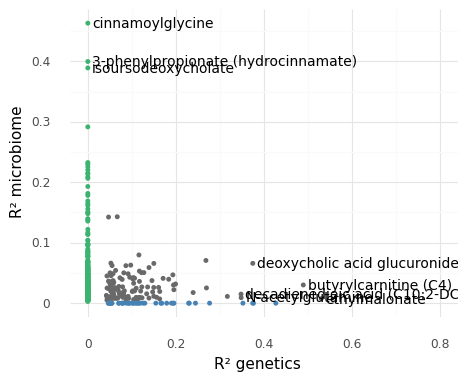

<ggplot: (8779946074067)>

In [10]:
from plotnine import *
from mizani.formatters import percent_format

pl = (
    ggplot(joint_r_sq, aes(x="geno_r2", y="micro_r2", color="group"))
    + geom_point(size=2, stroke=0)
    + geom_text(
        aes(label="BIOCHEMICAL_NAME"), 
        data=joint_r_sq[
            ((joint_r_sq.total > 0.35) & (joint_r_sq.group == "hybrid")) 
            | (joint_r_sq.micro_r2 > 0.35) 
            | (joint_r_sq.geno_r2 > 0.5)], 
        ha="left", nudge_x=0.01, size=10, color="black")
    + theme_minimal()
    + theme(figure_size=(5,4))
    + xlim(0, 0.8)
    + scale_color_manual(values={"genetics": "steelblue", "microbiome": "mediumseagreen", "hybrid": "dimgray"})
    + labs(x="R² genetics", y="R² microbiome") + guides(color=None)
)
pl.save("figures/train_r2.pdf", width=6, height=4)
pl

And we can also look at the most prevalent metabolites.

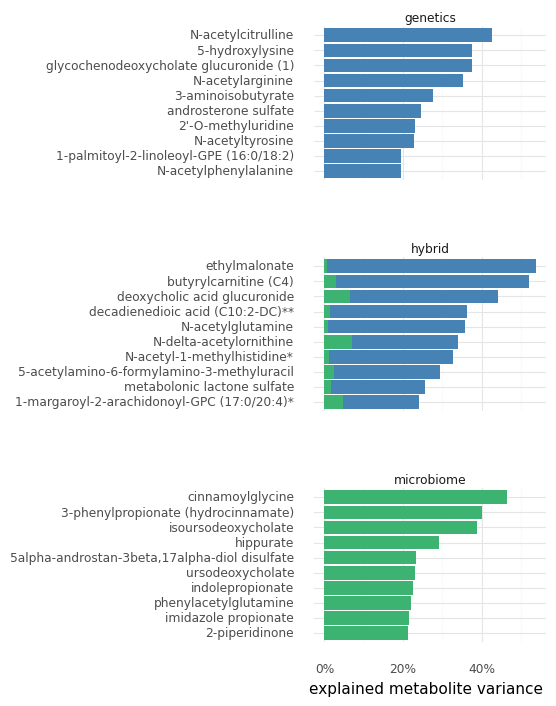

<ggplot: (8779889946344)>

In [11]:
pl = (
    ggplot(long[(long.r2 > 0.0) & (long.metabolite.isin(top))].sort_values(by="r2"), aes(y="r2", x="BIOCHEMICAL_NAME", fill="type"))
    + geom_bar(stat="identity") 
    + scale_y_continuous(labels=percent_format())
    + coord_flip()
    + facet_wrap("~ group", scales="free_y", ncol=1)
    + labs(y = "explained metabolite variance", x="")
    + scale_fill_manual(values=["steelblue", "mediumseagreen"])
    + guides(fill = None)
    + theme_minimal() 
    + theme(figure_size=(3, 8), subplots_adjust={"hspace": 0.5})
)
pl.save("figures/train_specific_r2.pdf", width=3, height=6)
pl

And we can ask what fractions of metabolites fall into each group.

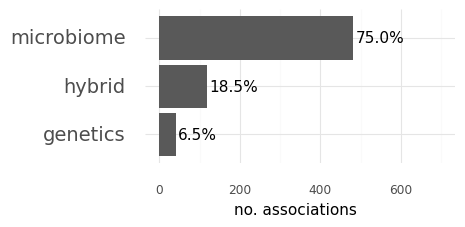

<ggplot: (8779889477753)>

In [12]:
pl = (
    ggplot(joint_r_sq, aes(x="group"))
    + geom_bar() 
    + theme_minimal()
    + theme(figure_size=(4, 2), axis_text_y = element_text(size=14))
    + ylim(0, 700)
    + labs(x="", y="no. associations")
    + geom_text(
     aes(label=after_stat('prop*100'), group=1),
     stat='count',
     nudge_y=5.0,
     va='center',
     ha="left",
     format_string='{:.1f}%'
     )
    + coord_flip()
  
)
pl.save("figures/train_type_fractions.pdf", width=4, height=2)
pl

## Feature overlap

An additional check we can run is whether the genetic and microbiome variance components have any overlap. For that we run joined models for all hybrid metabolites and will track the variance explained by the joint model as well.

In [13]:
hybrids = joint_r_sq.metabolite[joint_r_sq.group == "hybrid"]

combined_r2 = []
combined_fits = {}
for met in track(hybrids):
    snps = sig_snps.SNP[sig_snps.metabolite == met] #.str.split(";").str[0]
    snp_terms = ["Q('%s')" % s for s in snps]
    geno = pd.DataFrame({s: genotypes.get_geno_marker(s) for s in snps}, index=genome_ids)
    mics = sig_microbes.taxon[sig_microbes.metabolite == met]
    mterms = ["Q('%s')" % m for m in mics]
    df = pd.merge(metabolites[["genome_id", "stool_sample_id", met]], geno, left_on="genome_id", right_index=True)
    df = pd.merge(df, metabolites_and_microbes[["stool_sample_id"] + mics.to_list()], on="stool_sample_id")
    formula = f"{met} ~ {' + '.join(snp_terms + mterms)}"
    fit = smf.ols(formula, data=df).fit()
    metrics = pd.DataFrame({
        "metabolite": met,
        "n_taxa": len(mics),
        "combined_r2": fit.rsquared,
        "joint_f": fit.fvalue,
        "joint_p": fit.f_pvalue
    }, index=[met])
    combined_r2.append(metrics)
    combined_fits[met] = fit
combined_r2 = pd.concat(combined_r2)
with open("data/train_combined_fits.pkl", "wb") as out:
    pickle.dump(combined_fits, out)
combined_r2["joint_q"] = fdrcorrection(combined_r2.joint_p)[1]

Output()

In [14]:
combined_r2 = pd.merge(combined_r2, joint_r_sq.reset_index(drop=True), on="metabolite")
combined_r2

,metabolite,n_taxa,combined_r2,joint_f,joint_p,joint_q,n_taxa_x,micro_r2,micro_f,micro_p,...,geno_p,geno_q,CHEMICAL_ID,BIOCHEMICAL_NAME,SUPER_PATHWAY,SUB_PATHWAY,CAS,KEGG,total,group
0,metabolite_2054,1,0.533153,30.902020,7.473863e-128,8.893898e-126,1.0,0.007357,7.063628,7.998142e-03,...,2.460373e-127,4.477878e-125,2054,ethylmalonate,Amino Acid,"Leucine, Isoleucine and Valine Metabolism",601-75-2,NaN,0.537439,hybrid
1,metabolite_100001054,3,0.502133,26.964332,7.851727e-114,4.671777e-112,3.0,0.030116,9.729471,2.515561e-06,...,3.602822e-111,3.278568e-109,100001054,butyrylcarnitine (C4),Lipid,Fatty Acid Metabolism (also BCAA Metabolism),25576-40-3,C02862,0.519460,hybrid
2,metabolite_100020550,16,0.439909,25.453517,1.920198e-91,7.616787e-90,16.0,0.065852,3.903629,3.793327e-07,...,3.042515e-83,9.228962e-82,100020550,deoxycholic acid glucuronide,Lipid,Secondary Bile Acid Metabolism,NaN,NaN,0.440473,hybrid
3,metabolite_100021711,1,0.359634,30.425826,2.505641e-77,7.454281e-76,1.0,0.014988,14.257545,1.694605e-04,...,1.408007e-74,2.562573e-73,100021711,decadienedioic acid (C10:2-DC)**,Lipid,"Fatty Acid, Dicarboxylate",NaN,NaN,0.362964,hybrid
4,metabolite_100001253,1,0.352798,35.432255,2.689500e-76,6.401010e-75,1.0,0.009125,8.500281,3.636813e-03,...,1.010659e-75,2.043776e-74,100001253,N-acetylglutamine,Amino Acid,Glutamate Metabolism,2490-97-3,C02716,0.357305,hybrid
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114,metabolite_100000743,1,0.055005,27.386017,2.752157e-12,2.924167e-12,1.0,0.012823,12.236433,4.905640e-04,...,1.946093e-10,1.956845e-10,100000743,2-hydroxyoctanoate,Lipid,"Fatty Acid, Monohydroxy",617-73-2,NaN,0.054948,hybrid
115,metabolite_100004328,1,0.055410,27.658460,2.124211e-12,2.298010e-12,1.0,0.008539,8.130672,4.447153e-03,...,3.050552e-11,3.304765e-11,100004328,"sphingomyelin (d18:1/14:0, d16:1/16:0)*",Lipid,Sphingolipid Metabolism,NaN,NaN,0.054249,hybrid
116,metabolite_100001990,1,0.051218,25.587994,1.502621e-11,1.528306e-11,1.0,0.008760,8.387070,3.865735e-03,...,4.178084e-11,4.420996e-11,100001990,taurocholenate sulfate*,Lipid,Secondary Bile Acid Metabolism,NaN,NaN,0.053615,hybrid
117,metabolite_100001254,1,0.054044,27.537388,2.343220e-12,2.512101e-12,1.0,0.009406,9.163027,2.535113e-03,...,5.213488e-11,5.453189e-11,100001254,N-acetyltryptophan,Amino Acid,Tryptophan Metabolism,1218-34-4,C03137,0.053104,hybrid


In [15]:
combined_r2['additive_tick_loc'] = combined_r2.index.values*2 + 0.375
combined_r2['joint_tick_loc'] = combined_r2.index.values*2 + 1.125
combined_r2['lable_tick_loc'] = combined_r2.index.values*2 + 0.75

And let's visualize the difference between the joint and individual models.

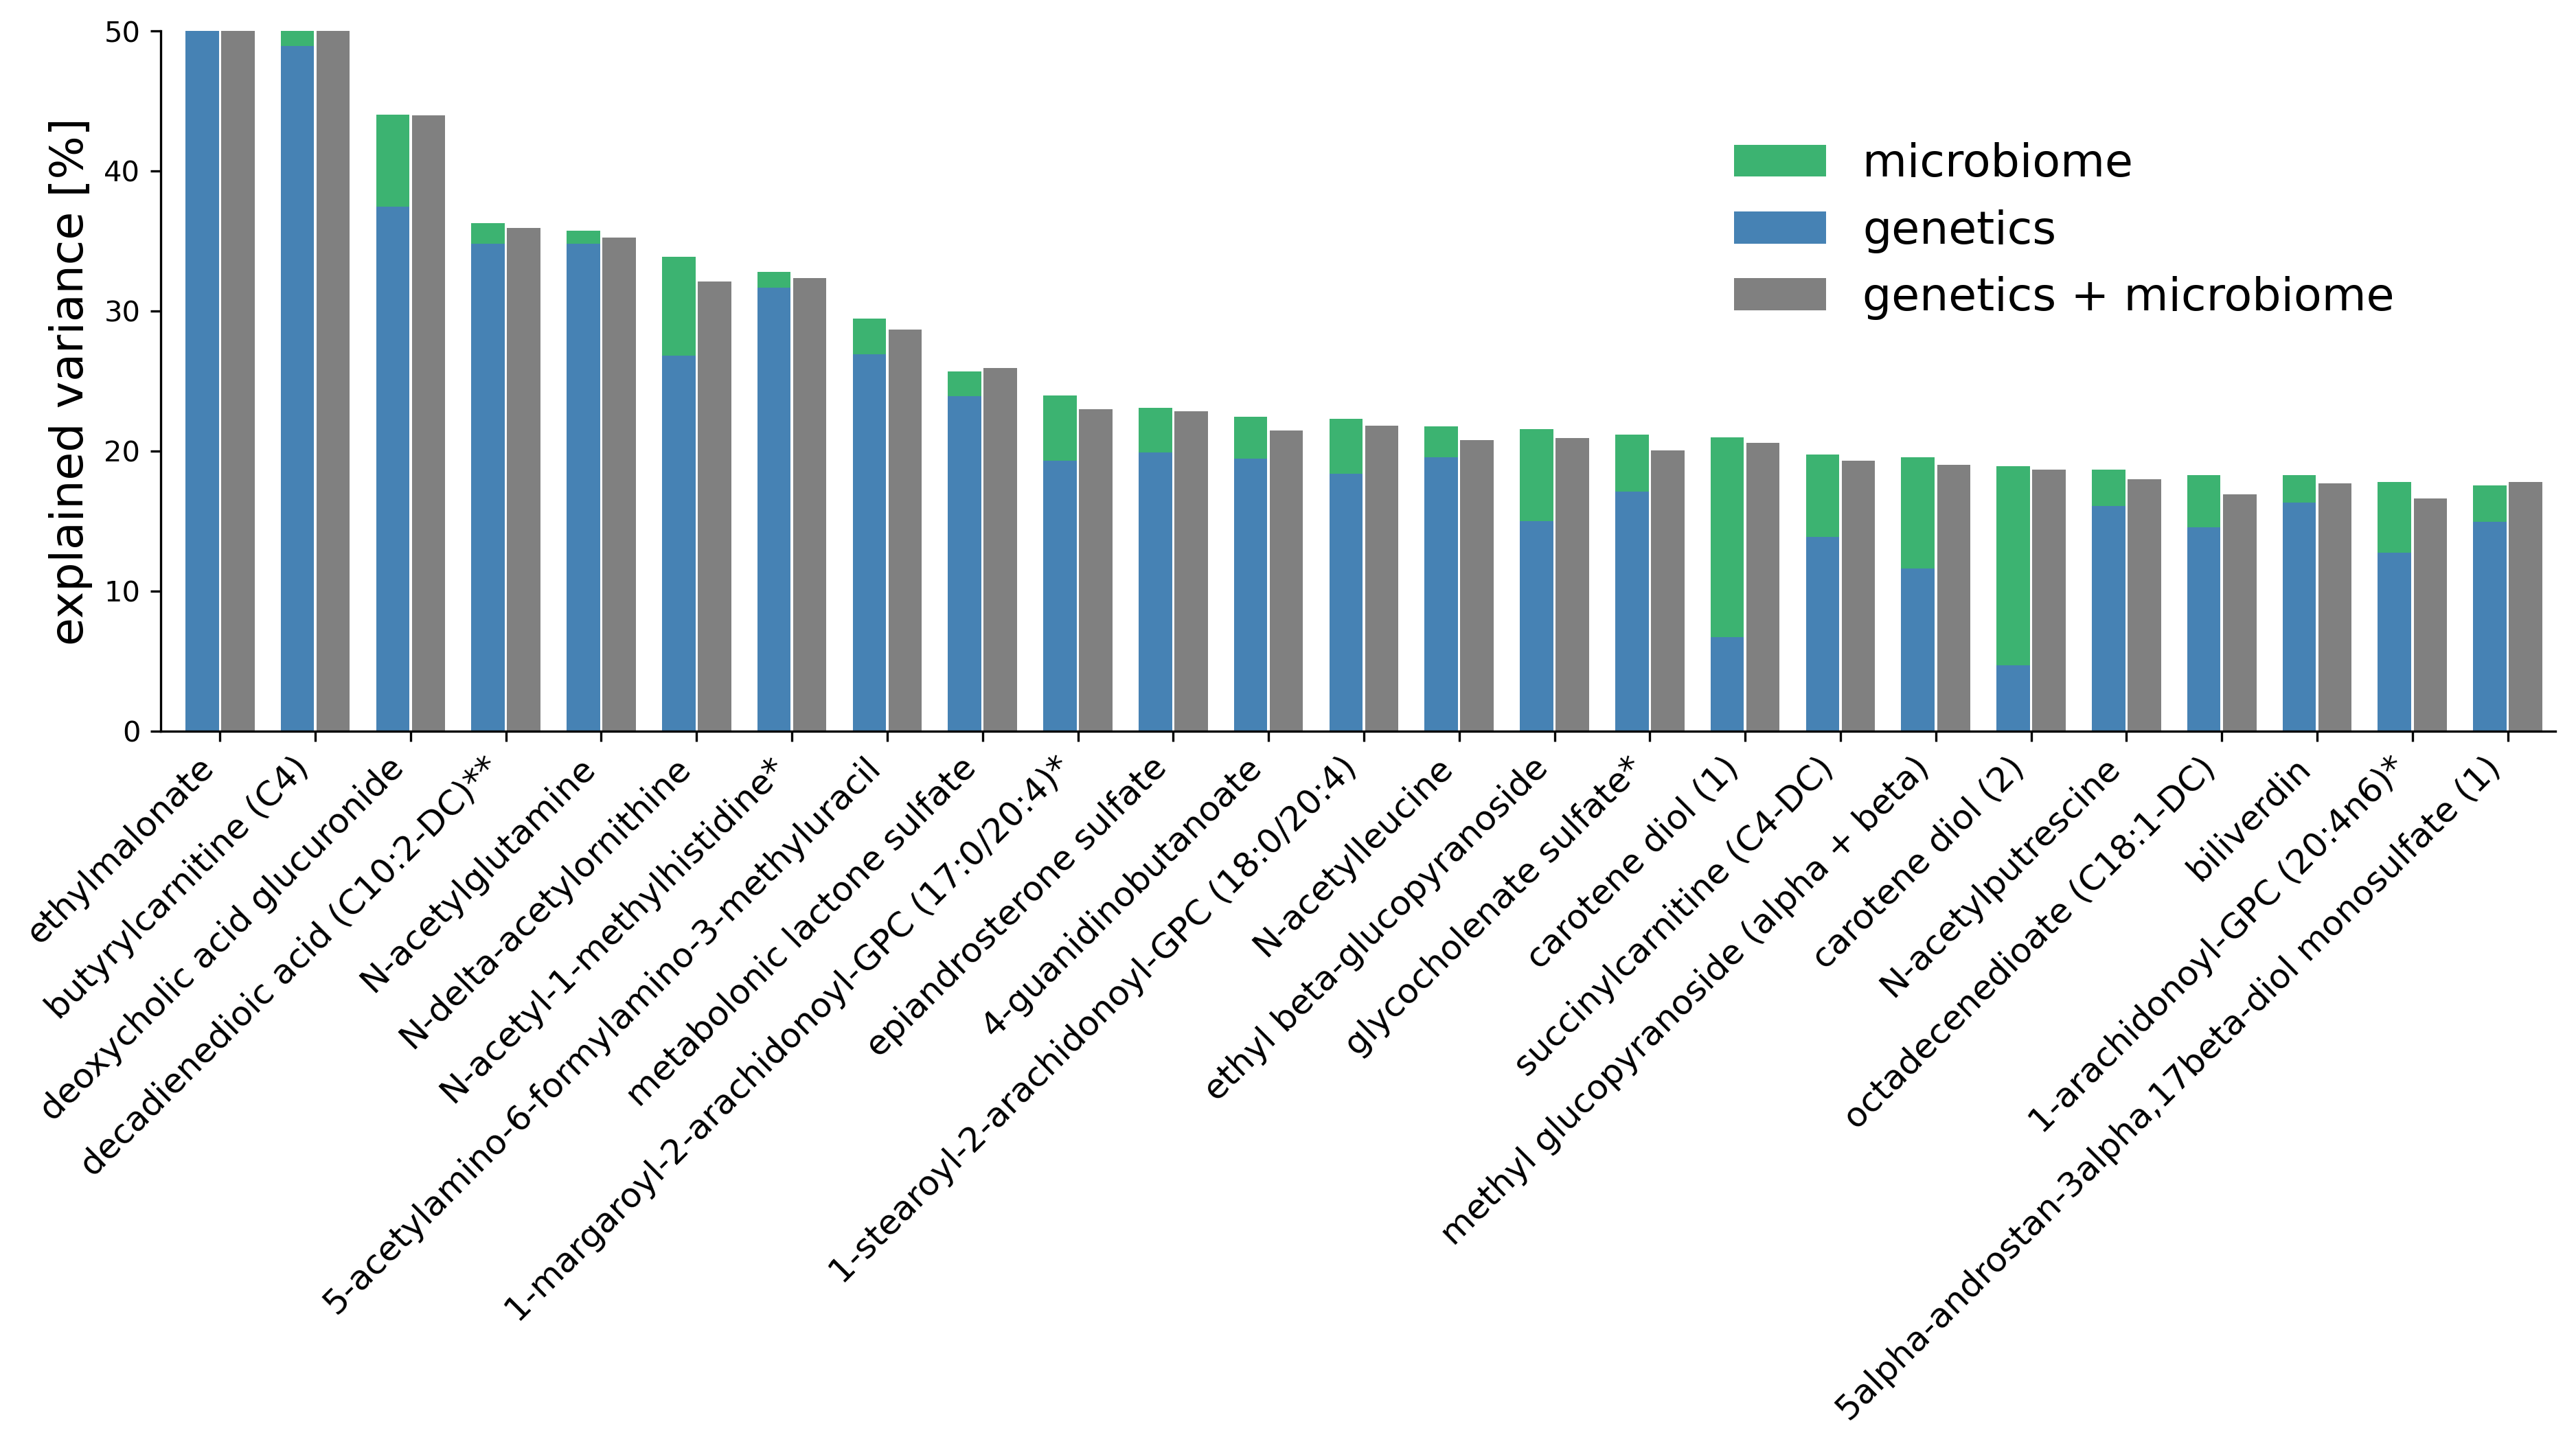

In [16]:
import matplotlib.pyplot as plt
import numpy
import seaborn as sns

cutoff = 25
range_max = int(numpy.round(combined_r2['combined_r2'].max(), 1) * 100)

joint_subset = combined_r2.iloc[:cutoff,:]

fig = plt.figure(figsize=(15, 4.5), dpi = 300)
ax = plt.subplot()
ax.bar(joint_subset["additive_tick_loc"], joint_subset["total"], width=0.7,
            label="microbiome", color="mediumseagreen")
ax.bar(joint_subset["additive_tick_loc"], joint_subset["geno_r2"],width=0.7,
            label="genetics", color="steelblue")
ax.bar(joint_subset["joint_tick_loc"], joint_subset["combined_r2"],width=0.7,
            label="genetics + microbiome", color="grey")
sns.despine()
ax.set_ylim([0,range_max/100])
ax.set_xlim([-0.5,max(joint_subset['lable_tick_loc'].values) + 1])
ax.set_yticklabels(list(range(0,range_max + 10,10)), fontdict={'size':10})
ax.set_xticks((joint_subset['lable_tick_loc'].values))
ax.set_xticklabels(joint_subset['BIOCHEMICAL_NAME'], fontdict={'size':12}, rotation = 45, ha = 'right')
ax.set_ylabel('explained variance [%]', fontdict={'size':16})
ax.set_xlabel('')
ax.legend(bbox_to_anchor = (0.95, 0.9), frameon=False, prop={'size': 16})
plt.savefig("figures/train_hybrid_r2.pdf", pad_inches=0.1, bbox_inches="tight")
plt.show()
plt.close()

And we can look for significant overlap.

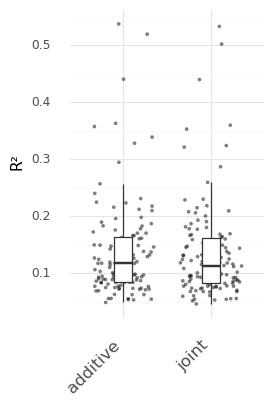

<ggplot: (8779946181858)>

In [17]:
model_comp = combined_r2[["BIOCHEMICAL_NAME", "total", "combined_r2"]].rename(columns={"total": "additive", "combined_r2": "joint"}).melt(id_vars="BIOCHEMICAL_NAME", var_name="type", value_name="r2")
pl = (
    ggplot(model_comp, aes(x="type", y="r2"))
    + geom_jitter(height=0, width=0.35, alpha=0.5, stroke=0)
    + geom_boxplot(width=0.2, outlier_color="none")
    + theme_minimal()
    + labs(x="", y="R²")
    + theme(figure_size=(2.5, 4), axis_text_x = element_text(angle=45, ha="right", va="top", size=12))
)
pl.save("figures/train_r2_overlap.pdf", width=2.5, height=4)
pl

In [18]:
from scipy.stats import wilcoxon

print((combined_r2.total - combined_r2.combined_r2).describe())
wilcoxon(combined_r2.total, combined_r2.combined_r2)

count    119.000000
mean       0.002814
std        0.004284
min       -0.011099
25%        0.000477
50%        0.002372
75%        0.004635
max        0.017658
dtype: float64


WilcoxonResult(statistic=1055.0, pvalue=2.5701824073089526e-11)